In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import numpy as np

from src.optics.channel_simulation import ChannelSimulator
from src.optics.split_step_fourier import SplitStepFourier
from src.general_methods.visualizer import Visualizer

# Channel Simulation
here starts the actual channel simulator code.

In [37]:
modify_t0 = 1e0
modify_h = 2e0
modify_au = 1e0

ssf_dt = 1e-12  # 1e-12
channel_dt = 1
zn = 1.51

# test_verbose = False

cs = ChannelSimulator(m_qam=16,
                      num_symbols=512,
                      normalization_factor=1e-3*modify_au,
                      dt=channel_dt,
                      ssf=SplitStepFourier(
                          b2=-20e-27,
                          gamma=0.003,
                          t0=125e-12*modify_t0,
                          dt=ssf_dt,
                          z_n=zn,
                          h=500*modify_h
                      ),
                      verbose=True,
                      test_verbose=True)

np.set_printoptions(threshold=250)

SSF params: N = 1179, P_0 = 0.00042666666666666667
number of iterations in split step algo: 1179


In [38]:
cs.step0_gen_msg()  # generate message


_______________________________________________
message before channel - len=2048
[[0 1 0 0]
 [0 1 0 1]
 [0 0 0 1]
 ...
 [0 0 1 1]
 [0 1 1 1]
 [0 0 0 0]]


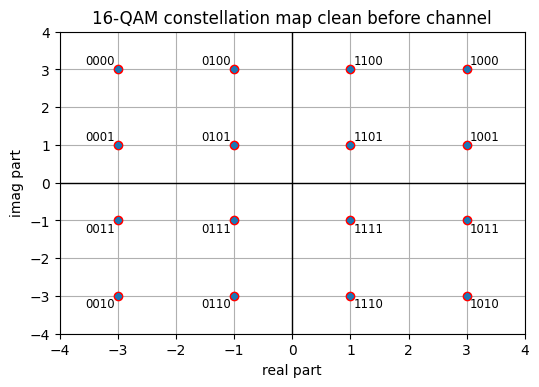

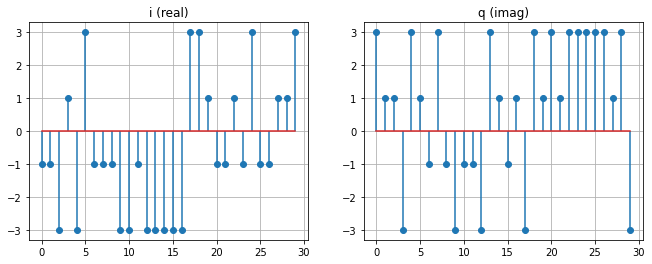

num of symbols = 512

_______________________________________________
test reconstructed msg - len=2048
[[0. 1. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 1.]
 [0. 1. 1. 1.]
 [0. 0. 0. 0.]]

_______________________________________________
message before channel - len=2048
[[0 1 0 0]
 [0 1 0 1]
 [0 0 0 1]
 ...
 [0 0 1 1]
 [0 1 1 1]
 [0 0 0 0]]
ber = 0.0 = 0/2048


In [39]:
cs.step1_modulate()  # modulate

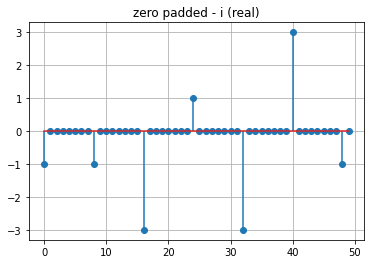

vec length = 4096, over_sampling period = 8


In [40]:
cs.step2_over_sample()  # over sample

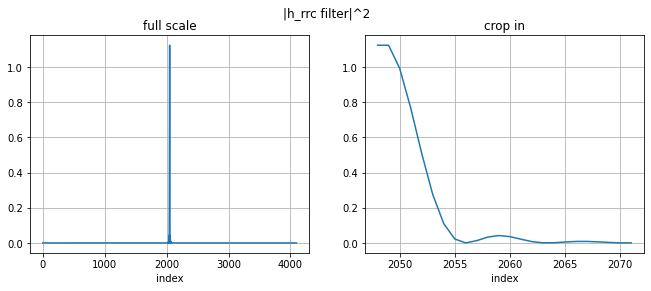

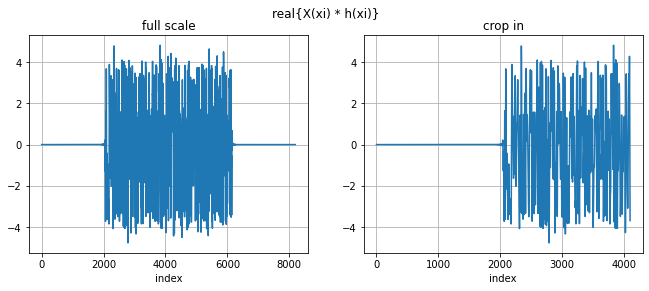

filter len = 4097, signal len = 8192


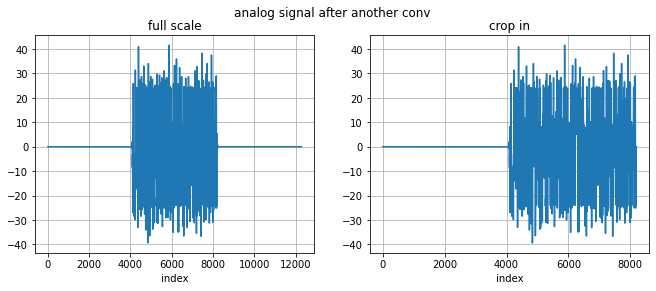

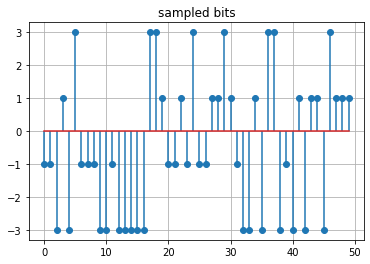

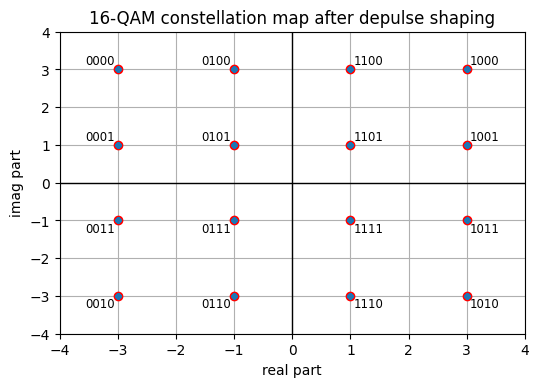

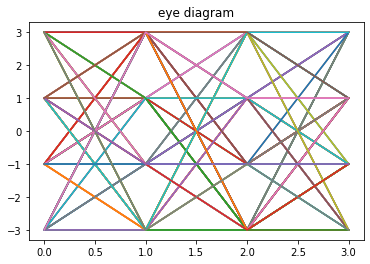

In [41]:
cs.step3_pulse_shaping()  # pulse shaping

xi ∈ [-0.00:0.00] GHz ,	 N_xi   (=M) = 8192
t  ∈ [-4096000000000000.00:4095000000000000.00] ps    ,	 N_time (=D) = 8192
BW = 0.00 GHz


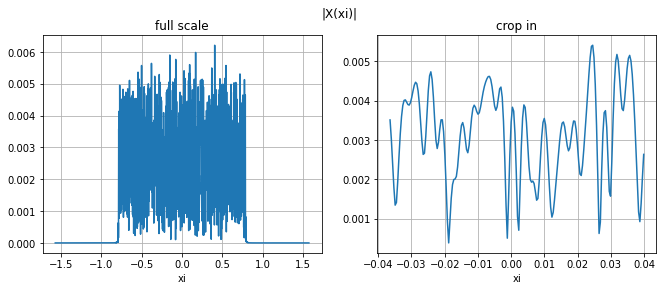

signal len = 8192


In [42]:
cs.step4_pre_equalize()  # pre equalize (equalize before inft)

length of INFT(x) = 8192
signal power = 2.23e-03
signal bw = [-6.34e+02:6.32e+02]


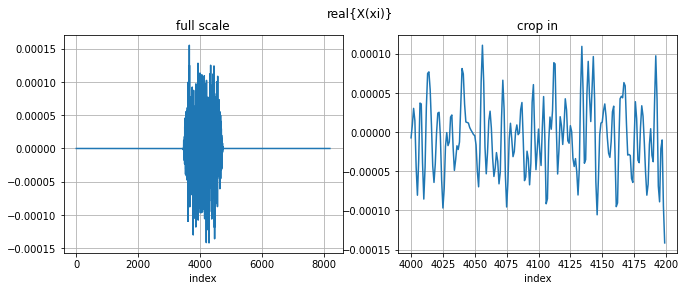

In [43]:
# cs.step5_inft()  # inft
cs.x[5] = cs.cb.inft(cs.x[4], cs.tvec, cs.xivec)  # , self.P_0)

print(f'length of INFT(x) = {len(cs.x[5])}')
Visualizer.print_signal_specs(cs.x[5], cs.tvec)
Visualizer.twin_zoom_plot('real{X(xi)}', np.real(cs.x[5]), range(4000, 4200))


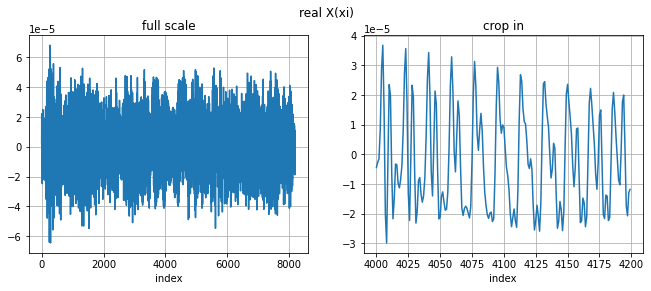

the dist between before and after channel vecs is: 1.4189173227681993


In [44]:
cs.step6_channel()  # channel (ssf)
norm2 = np.linalg.norm(cs.x[6]-cs.x[5],2)/np.linalg.norm(cs.x[5],2)
print(f'the dist between before and after channel vecs is: {norm2}')

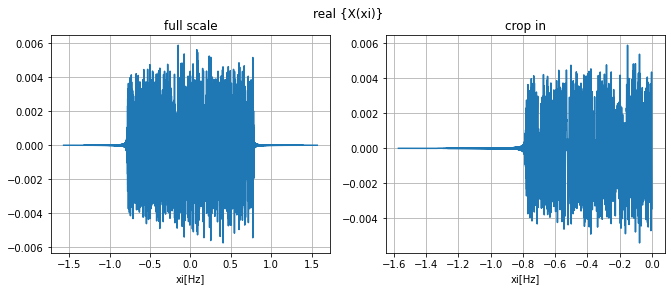

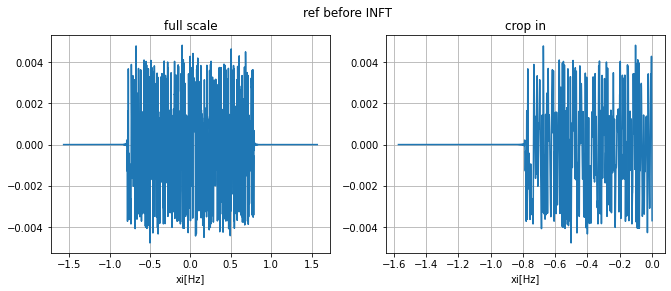

In [45]:
cs.step7_nft()  # nft

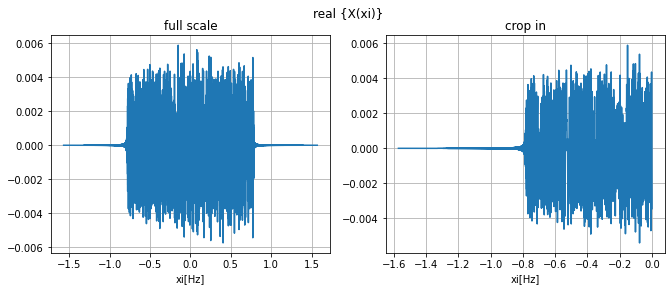

In [46]:
# phase compensation
phase_compensator = np.exp(-1j*cs.xivec**2 * zn/cs.N_xi)
x72 = cs.x[7] * phase_compensator
zm = range(0, cs.N_rrc)
Visualizer.twin_zoom_plot('real {X(xi)}', np.real(x72), zm, cs.xivec, 'xi[Hz]')
cs.x[7] = x72

In [47]:
cs.step8_equalize()  # equalizer

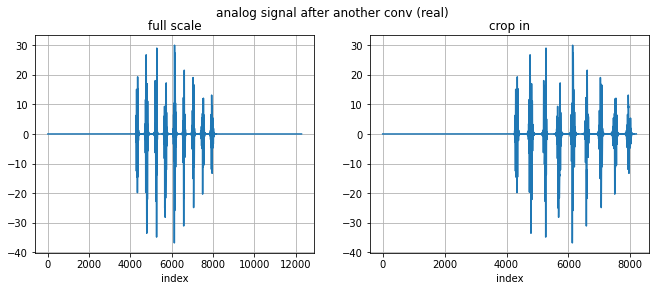

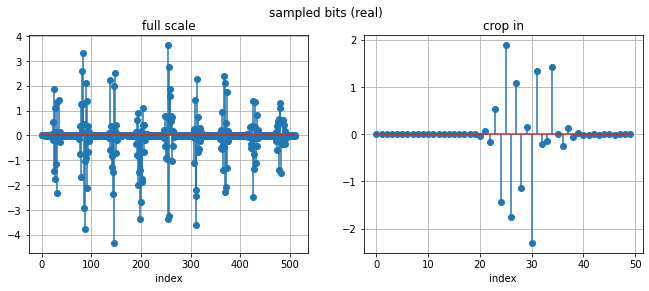

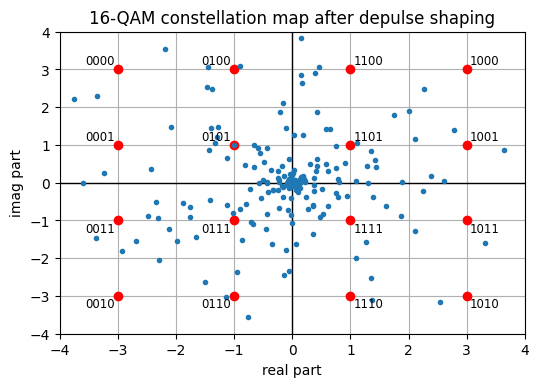

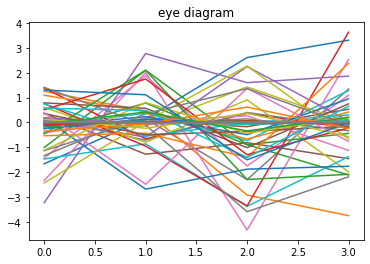

num of sampled symbols = 512 


In [48]:
cs.step9_match_filter()  # match filter

In [49]:
cs.step10_demodulate()  # demod()


_______________________________________________
message after channel - len=2048
[[1. 1. 1. 1.]
 [0. 1. 0. 1.]
 [1. 1. 1. 1.]
 ...
 [1. 1. 1. 1.]
 [1. 1. 0. 1.]
 [0. 1. 0. 1.]]


In [50]:
ber, num_errors = cs.evaluate()

ber = 0.48974609375 = 1003/2048
